In [1]:
# lstm many to many的一个示例：股票价格预测
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

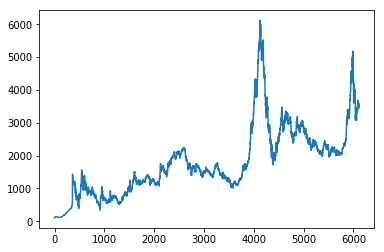

In [2]:
f=open('./data/dataset_1.csv')  
df=pd.read_csv(f)     # 读入股票数据
data=np.array(df['最高价'])   # 获取最高价序列
data=data[::-1]      # 反转，使数据按照日期先后顺序排列
#以折线图展示data
plt.figure()
plt.plot(data)
plt.show()


In [3]:
normalize_data=(data-np.mean(data))/np.std(data)  # 标准化
normalize_data=normalize_data[:,np.newaxis]       # 增加维度 6111 --> (6111, 1)

In [4]:
#生成训练集
#设置常量
time_step=20      #时间步
rnn_unit=10       #hidden layer units
batch_size=60     #每一批次训练多少个样例
input_size=1      #输入层维度
output_size=1     #输出层维度
lr=0.0006         #学习率
train_x,train_y=[],[]   #训练集
# 这是典型的seq to seq用法，训练集由当前天的股价以及之后一天的股价组成
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]  # x的长度是20个时间步， 按照顺序依次取data中当前元素及其后的20个
    y=normalize_data[i+1:i+time_step+1]  # y的长度是20个时间步，依次取x中每个元素的后一个元素
    train_x.append(x.tolist())
    train_y.append(y.tolist())

In [5]:
# 训练数据中的元素如下：
print(train_x[0])
print('*'*80)
print(train_y[0])

[[-1.5961875451103236], [-1.5920289935368048], [-1.5875592578319344], [-1.5824482942200362], [-1.577073295587597], [-1.5723395248621856], [-1.5723300950400234], [-1.571226805847049], [-1.570132946476237], [-1.5689730783502895], [-1.567747201469207], [-1.5665213245881242], [-1.5659366756140696], [-1.5653520266400147], [-1.5647296583773114], [-1.5641355795810943], [-1.563532070962715], [-1.562985141277309], [-1.5634094832746068], [-1.5634094832746068]]
********************************************************************************
[[-1.5920289935368048], [-1.5875592578319344], [-1.5824482942200362], [-1.577073295587597], [-1.5723395248621856], [-1.5723300950400234], [-1.571226805847049], [-1.570132946476237], [-1.5689730783502895], [-1.567747201469207], [-1.5665213245881242], [-1.5659366756140696], [-1.5653520266400147], [-1.5647296583773114], [-1.5641355795810943], [-1.563532070962715], [-1.562985141277309], [-1.5634094832746068], [-1.5634094832746068], [-1.5638715445605533]]


In [6]:
# 定义神经网络
X=tf.placeholder(tf.float32, [None,time_step,input_size])  #每批次输入网络的tensor，每次从x中读取20个元素。元素的维度是1
Y=tf.placeholder(tf.float32, [None,time_step,output_size]) #每批次tensor对应的标签
#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }


In [7]:
# 定义lstm
def lstm(batch):      #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，由原先的长度为20的list变成shape=(20, 1)的tensor
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    # cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    with tf.variable_scope('cell_def', reuse=tf.AUTO_REUSE):
        cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    # 使用下面这种会报错
    # output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32) 
    
    # output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    with tf.variable_scope('rnn_def', reuse=tf.AUTO_REUSE):
        output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn,
                                             initial_state=init_state,
                                             dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [8]:
# 训练lstm
global batch_size
pred,_=lstm(batch_size)
#损失函数
loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
train_op=tf.train.AdamOptimizer(lr).minimize(loss)
saver=tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #重复训练10000次
    for i in range(1000):
        step=0
        start=0
        end=start+batch_size
        while(end<len(train_x)):
            _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
            start+=batch_size
            end=start+batch_size
            #每10步保存一次参数
            if step%100==0:
                print(i,step,loss_)
                print("保存模型：",saver.save(sess,'./stock.model'))
            step+=1

0 0 1.9093229
保存模型： ./stock.model
0 100 0.14299041
保存模型： ./stock.model
1 0 0.15460943
保存模型： ./stock.model
1 100 0.11682302
保存模型： ./stock.model
2 0 0.19473585
保存模型： ./stock.model
2 100 0.09812453
保存模型： ./stock.model
3 0 0.18145011
保存模型： ./stock.model
3 100 0.08124732
保存模型： ./stock.model
4 0 0.14034206
保存模型： ./stock.model
4 100 0.07105527
保存模型： ./stock.model
5 0 0.10475693
保存模型： ./stock.model
5 100 0.063728064
保存模型： ./stock.model
6 0 0.0822643
保存模型： ./stock.model
6 100 0.057791352
保存模型： ./stock.model
7 0 0.06857902
保存模型： ./stock.model
7 100 0.05271408
保存模型： ./stock.model
8 0 0.06009627
保存模型： ./stock.model
8 100 0.048248366
保存模型： ./stock.model
9 0 0.054539338
保存模型： ./stock.model
9 100 0.04427091
保存模型： ./stock.model
10 0 0.050616004
保存模型： ./stock.model
10 100 0.04072146
保存模型： ./stock.model
11 0 0.04765766
保存模型： ./stock.model
11 100 0.037557635
保存模型： ./stock.model
12 0 0.045326903
保存模型： ./stock.model
12 100 0.03473977
保存模型： ./stock.model
13 0 0.0434476
保存模型： ./stock.model
13 100 0.032228958

108 100 0.0077652754
保存模型： ./stock.model
109 0 0.0022083325
保存模型： ./stock.model
109 100 0.0076712575
保存模型： ./stock.model
110 0 0.0027355626
保存模型： ./stock.model
110 100 0.007592097
保存模型： ./stock.model
111 0 0.0036849913
保存模型： ./stock.model
111 100 0.0075681685
保存模型： ./stock.model
112 0 0.005054459
保存模型： ./stock.model
112 100 0.0077360263
保存模型： ./stock.model
113 0 0.005683785
保存模型： ./stock.model
113 100 0.008157736
保存模型： ./stock.model
114 0 0.0035355883
保存模型： ./stock.model
114 100 0.008488731
保存模型： ./stock.model
115 0 0.0015296369
保存模型： ./stock.model
115 100 0.008455133
保存模型： ./stock.model
116 0 0.0016756682
保存模型： ./stock.model
116 100 0.008070222
保存模型： ./stock.model
117 0 0.0014849163
保存模型： ./stock.model
117 100 0.00772136
保存模型： ./stock.model
118 0 0.0011083182
保存模型： ./stock.model
118 100 0.0076178596
保存模型： ./stock.model
119 0 0.0020746924
保存模型： ./stock.model
119 100 0.007590208
保存模型： ./stock.model
120 0 0.00559014
保存模型： ./stock.model
120 100 0.007733086
保存模型： ./stock.model
121 0 0.0104

212 100 0.00741028
保存模型： ./stock.model
213 0 0.0024541817
保存模型： ./stock.model
213 100 0.007796859
保存模型： ./stock.model
214 0 0.0037651625
保存模型： ./stock.model
214 100 0.008039385
保存模型： ./stock.model
215 0 0.0013450205
保存模型： ./stock.model
215 100 0.0075923363
保存模型： ./stock.model
216 0 0.00049020065
保存模型： ./stock.model
216 100 0.00742277
保存模型： ./stock.model
217 0 0.00045940006
保存模型： ./stock.model
217 100 0.007344799
保存模型： ./stock.model
218 0 0.0012848598
保存模型： ./stock.model
218 100 0.0075914413
保存模型： ./stock.model
219 0 0.0035996477
保存模型： ./stock.model
219 100 0.008017189
保存模型： ./stock.model
220 0 0.0024167618
保存模型： ./stock.model
220 100 0.007770424
保存模型： ./stock.model
221 0 0.0006581425
保存模型： ./stock.model
221 100 0.007521437
保存模型： ./stock.model
222 0 0.00046408345
保存模型： ./stock.model
222 100 0.007362451
保存模型： ./stock.model
223 0 0.0005094701
保存模型： ./stock.model
223 100 0.007386033
保存模型： ./stock.model
224 0 0.0023043745
保存模型： ./stock.model
224 100 0.007744824
保存模型： ./stock.model
225 0 0.0

316 100 0.007604413
保存模型： ./stock.model
317 0 0.002461119
保存模型： ./stock.model
317 100 0.007833213
保存模型： ./stock.model
318 0 0.0007535861
保存模型： ./stock.model
318 100 0.0075488756
保存模型： ./stock.model
319 0 0.00033223093
保存模型： ./stock.model
319 100 0.0073473
保存模型： ./stock.model
320 0 0.0002739516
保存模型： ./stock.model
320 100 0.0072535197
保存模型： ./stock.model
321 0 0.00083424797
保存模型： ./stock.model
321 100 0.007301614
保存模型： ./stock.model
322 0 0.0032294404
保存模型： ./stock.model
322 100 0.0075983126
保存模型： ./stock.model
323 0 0.0032036265
保存模型： ./stock.model
323 100 0.007909735
保存模型： ./stock.model
324 0 0.00082949025
保存模型： ./stock.model
324 100 0.0075006788
保存模型： ./stock.model
325 0 0.00034795565
保存模型： ./stock.model
325 100 0.0073152576
保存模型： ./stock.model
326 0 0.00026828132
保存模型： ./stock.model
326 100 0.007264959
保存模型： ./stock.model
327 0 0.0010096923
保存模型： ./stock.model
327 100 0.0073521216
保存模型： ./stock.model
328 0 0.0024543128
保存模型： ./stock.model
328 100 0.0076177646
保存模型： ./stock.model
329

420 100 0.0076129595
保存模型： ./stock.model
421 0 0.0015339181
保存模型： ./stock.model
421 100 0.0075761285
保存模型： ./stock.model
422 0 0.0015551902
保存模型： ./stock.model
422 100 0.0076046786
保存模型： ./stock.model
423 0 0.0015047257
保存模型： ./stock.model
423 100 0.0075640576
保存模型： ./stock.model
424 0 0.001542253
保存模型： ./stock.model
424 100 0.00760137
保存模型： ./stock.model
425 0 0.0014899966
保存模型： ./stock.model
425 100 0.0075685643
保存模型： ./stock.model
426 0 0.0015399903
保存模型： ./stock.model
426 100 0.0076016616
保存模型： ./stock.model
427 0 0.0014954263
保存模型： ./stock.model
427 100 0.00757607
保存模型： ./stock.model
428 0 0.0015324318
保存模型： ./stock.model
428 100 0.0076012667
保存模型： ./stock.model
429 0 0.0014957497
保存模型： ./stock.model
429 100 0.0075769727
保存模型： ./stock.model
430 0 0.0015167441
保存模型： ./stock.model
430 100 0.0075985473
保存模型： ./stock.model
431 0 0.0014810219
保存模型： ./stock.model
431 100 0.007571552
保存模型： ./stock.model
432 0 0.0014971661
保存模型： ./stock.model
432 100 0.007593598
保存模型： ./stock.model
433 0 

524 100 0.0075339903
保存模型： ./stock.model
525 0 0.0011453525
保存模型： ./stock.model
525 100 0.0075233188
保存模型： ./stock.model
526 0 0.0010428863
保存模型： ./stock.model
526 100 0.007550793
保存模型： ./stock.model
527 0 0.0009492866
保存模型： ./stock.model
527 100 0.0075018755
保存模型： ./stock.model
528 0 0.0011388654
保存模型： ./stock.model
528 100 0.0075077876
保存模型： ./stock.model
529 0 0.0010084016
保存模型： ./stock.model
529 100 0.007513024
保存模型： ./stock.model
530 0 0.00089685095
保存模型： ./stock.model
530 100 0.0075325975
保存模型： ./stock.model
531 0 0.0011400111
保存模型： ./stock.model
531 100 0.0075033023
保存模型： ./stock.model
532 0 0.0009908209
保存模型： ./stock.model
532 100 0.007547323
保存模型： ./stock.model
533 0 0.00096425065
保存模型： ./stock.model
533 100 0.0075159757
保存模型： ./stock.model
534 0 0.001128771
保存模型： ./stock.model
534 100 0.007495029
保存模型： ./stock.model
535 0 0.0009604484
保存模型： ./stock.model
535 100 0.0074936813
保存模型： ./stock.model
536 0 0.0009222266
保存模型： ./stock.model
536 100 0.0075332974
保存模型： ./stock.model
53

627 100 0.0075114537
保存模型： ./stock.model
628 0 0.0006959804
保存模型： ./stock.model
628 100 0.007461105
保存模型： ./stock.model
629 0 0.0008083894
保存模型： ./stock.model
629 100 0.007465377
保存模型： ./stock.model
630 0 0.0007715061
保存模型： ./stock.model
630 100 0.007484246
保存模型： ./stock.model
631 0 0.000662757
保存模型： ./stock.model
631 100 0.007500219
保存模型： ./stock.model
632 0 0.00090238114
保存模型： ./stock.model
632 100 0.0075190943
保存模型： ./stock.model
633 0 0.0006904266
保存模型： ./stock.model
633 100 0.007482885
保存模型： ./stock.model
634 0 0.000835683
保存模型： ./stock.model
634 100 0.007501663
保存模型： ./stock.model
635 0 0.0007718308
保存模型： ./stock.model
635 100 0.0075146183
保存模型： ./stock.model
636 0 0.0007047797
保存模型： ./stock.model
636 100 0.0075102677
保存模型： ./stock.model
637 0 0.00088102114
保存模型： ./stock.model
637 100 0.0075014434
保存模型： ./stock.model
638 0 0.0006806898
保存模型： ./stock.model
638 100 0.0074531524
保存模型： ./stock.model
639 0 0.0007570037
保存模型： ./stock.model
639 100 0.0074770735
保存模型： ./stock.model
640 0

730 100 0.007567904
保存模型： ./stock.model
731 0 0.0005090385
保存模型： ./stock.model
731 100 0.0075083557
保存模型： ./stock.model
732 0 0.00076176244
保存模型： ./stock.model
732 100 0.0075590014
保存模型： ./stock.model
733 0 0.00057089963
保存模型： ./stock.model
733 100 0.0074833543
保存模型： ./stock.model
734 0 0.0006027801
保存模型： ./stock.model
734 100 0.007518541
保存模型： ./stock.model
735 0 0.0006610693
保存模型： ./stock.model
735 100 0.0075379405
保存模型： ./stock.model
736 0 0.00045307548
保存模型： ./stock.model
736 100 0.0075109983
保存模型： ./stock.model
737 0 0.0007801904
保存模型： ./stock.model
737 100 0.0075297323
保存模型： ./stock.model
738 0 0.00049454195
保存模型： ./stock.model
738 100 0.0074525173
保存模型： ./stock.model
739 0 0.00063956133
保存模型： ./stock.model
739 100 0.007489035
保存模型： ./stock.model
740 0 0.0006041126
保存模型： ./stock.model
740 100 0.0075321374
保存模型： ./stock.model
741 0 0.00049025565
保存模型： ./stock.model
741 100 0.007512007
保存模型： ./stock.model
742 0 0.0007856365
保存模型： ./stock.model
742 100 0.0075699617
保存模型： ./stock.mod

833 100 0.0075244997
保存模型： ./stock.model
834 0 0.0003307761
保存模型： ./stock.model
834 100 0.007488297
保存模型： ./stock.model
835 0 0.00067899487
保存模型： ./stock.model
835 100 0.007540262
保存模型： ./stock.model
836 0 0.00039675305
保存模型： ./stock.model
836 100 0.00749324
保存模型： ./stock.model
837 0 0.00054227735
保存模型： ./stock.model
837 100 0.007514016
保存模型： ./stock.model
838 0 0.0005371773
保存模型： ./stock.model
838 100 0.007554622
保存模型： ./stock.model
839 0 0.00039148435
保存模型： ./stock.model
839 100 0.007517611
保存模型： ./stock.model
840 0 0.0006847505
保存模型： ./stock.model
840 100 0.007601947
保存模型： ./stock.model
841 0 0.00035949785
保存模型： ./stock.model
841 100 0.0074735866
保存模型： ./stock.model
842 0 0.000649287
保存模型： ./stock.model
842 100 0.0075277407
保存模型： ./stock.model
843 0 0.00040339108
保存模型： ./stock.model
843 100 0.007449592
保存模型： ./stock.model
844 0 0.00038302387
保存模型： ./stock.model
844 100 0.00749088
保存模型： ./stock.model
845 0 0.00057182857
保存模型： ./stock.model
845 100 0.007543828
保存模型： ./stock.model
846 

936 100 0.0075006103
保存模型： ./stock.model
937 0 0.00029456645
保存模型： ./stock.model
937 100 0.00748848
保存模型： ./stock.model
938 0 0.0005736766
保存模型： ./stock.model
938 100 0.007586975
保存模型： ./stock.model
939 0 0.00026089727
保存模型： ./stock.model
939 100 0.0074541997
保存模型： ./stock.model
940 0 0.0005776894
保存模型： ./stock.model
940 100 0.0075145913
保存模型： ./stock.model
941 0 0.00027914203
保存模型： ./stock.model
941 100 0.0074047437
保存模型： ./stock.model
942 0 0.0003281129
保存模型： ./stock.model
942 100 0.0074758464
保存模型： ./stock.model
943 0 0.0004258397
保存模型： ./stock.model
943 100 0.0075412877
保存模型： ./stock.model
944 0 0.00023883862
保存模型： ./stock.model
944 100 0.0074932915
保存模型： ./stock.model
945 0 0.0006545347
保存模型： ./stock.model
945 100 0.0075775385
保存模型： ./stock.model
946 0 0.0002363392
保存模型： ./stock.model
946 100 0.007417643
保存模型： ./stock.model
947 0 0.0005211956
保存模型： ./stock.model
947 100 0.0074660573
保存模型： ./stock.model
948 0 0.0002725145
保存模型： ./stock.model
948 100 0.007456332
保存模型： ./stock.model


INFO:tensorflow:Restoring parameters from .\stock.model


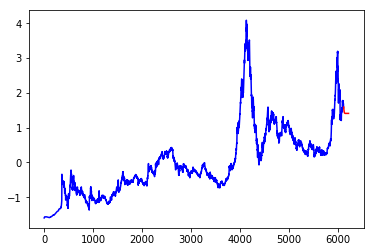

In [10]:
# 预测模型
pred,_=lstm(1)  # 预测时只输入[1,time_step,input_size]的测试数据
saver=tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    # 参数恢复
    module_file = tf.train.latest_checkpoint('.')
    saver.restore(sess, module_file) 

    # 取训练集最后一行为测试样本。shape=[1,time_step,input_size]
    prev_seq=train_x[-1]
    predict=[]
    # 得到数据集之后100个预测结果
    for i in range(100):
        next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
        predict.append(next_seq[-1])
        # 每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本，每次都是基于前一步的结果作为输入
        prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
    # 以折线图表示结果
    plt.figure()
    plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
    plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
    plt.show()
